# 5章　一次元入力の直線モデル
年齢と身長の人口データを作る

年齢から身長を予測する

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# データ生成
np.random.seed(seed=1)          # 乱数を固定
X_min, X_max = 4, 30            # Xの下限と上限（表示用）
N = 16                          # データ数
X = 5 + 25 * np.random.rand(N)  # Xの生成
print('X=', np.round(X, 3))
prm = [170, 108, 0.2]           # データ生成のパラメータ
T = prm[0] - prm[1] * np.exp(-prm[2] * X) + 4 * np.random.randn(N) # 目的変数の生成 randnは標準正規分布から乱数を引数で指定したshape分生成
print('T=', np.round(T, 3))
np.savez('ch5_data.npz', X=X, X_min=X_min, X_max=X_max, N=N, T=T)     # データを保存

X= [15.426 23.008  5.003 12.558  8.669  7.308  9.657 13.639 14.919 18.47
 15.48  22.13  10.111 26.953  5.685 21.762]
T= [170.91  160.676 129.002 159.701 155.461 140.561 153.655 159.429 164.704
 169.645 160.713 173.287 159.312 171.518 138.957 165.874]


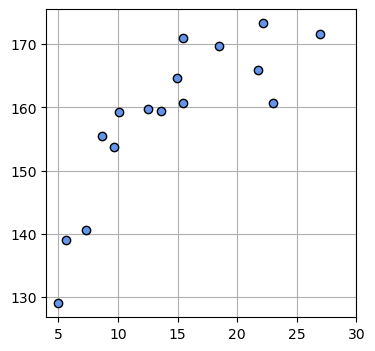

In [40]:
# データ表示
plt.figure(figsize=(4, 4))
plt.plot(
    X,                          # 入力
    T,                          # 目的変数
    marker='o',                 # 点を丸で表示
    linestyle='None',           # 線は引かない
    markeredgecolor='black',    # 点の周りを黒で塗りつぶす
    color='cornflowerblue'
    )

plt.xlim(X_min, X_max)          # X軸の範囲を指定
plt.grid()
plt.show()

## 5.1.3 平均2乗誤差
単回帰の重みWと、平均2乗誤差の関係をグラフに表してみる

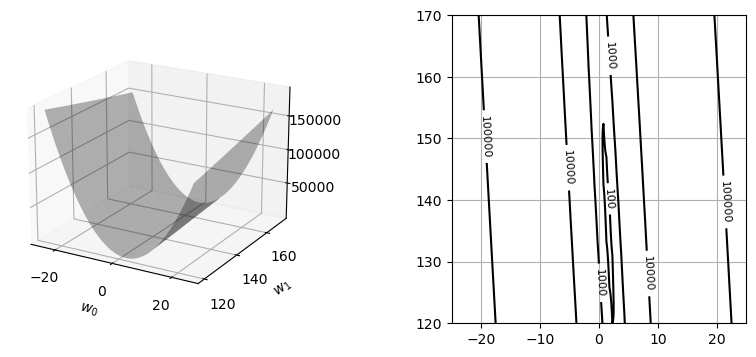

In [41]:
# 平均2乗誤差関数
def mse_line(x, t, w):
    y = w[0] * x + w[1]            # 1次関数
    mse = np.mean((y-t)**2)        # 平均2乗誤差
    return mse

# 各w0、w1で平均2乗誤差を求める
w0_n, w1_n = 100, 100               # w0, w1の試行数　グラフの解像度
w0_min, w0_max = -25, 25            # w0の範囲(係数)
w1_min, w1_max = 120, 170           # w1の範囲(切片)
w0 = np.linspace(w0_min, w0_max, w0_n) # w0_n個の数をw0_minからw0_maxまで等間隔に生成した配列
w1 = np.linspace(w1_min, w1_max, w1_n) # w1_n個の数をw1_minからw1_maxまで等間隔に生成した配列

J = np.zeros((w1_n, w0_n))      # 平均2乗誤差を入れる配列
# この行列の各要素に平均2乗誤差を求める
for i0 in range(w0_n):
    for i1 in range(w1_n):
        w = np.array([w0[i0], w1[i1]])
        J[i1, i0] = mse_line(X, T, w)
ww0, ww1 = np.meshgrid(w0, w1)   # w0とw1の値からなるグリッドを作成

# グラフ描画
plt.figure(figsize=(9.5, 4))
plt.subplots_adjust(wspace=0.5)
# サーフェス表示
ax = plt.subplot(1, 2, 1, projection='3d')
ax.plot_surface(
    ww0, ww1, J,
    rstride=10, cstride=10, alpha=0.3, color='black',
)
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120, 140, 160])
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
ax.view_init(20, -60)

# 等高線表示
plt.subplot(1, 2, 2)
cont = plt.contour(ww0, ww1, J, colors='black',
                   levels=[100, 1000, 10000, 100000]) # 等高線の値を指定
cont.clabel(fmt='%d', fontsize=8) # 等高線の値を表示
plt.grid()
plt.show()

## 5.1.4 パラメータを求める(勾配法（最急降下法))


In [42]:
# wにおいての平均二乗誤差（MSE）の勾配
def dmse_line(x, t, w):
    y = w[0] * x + w[1]            # 1次関数
    d_w0 = 2 * np.mean((y-t) * x)  # w0で微分
    d_w1 = 2 * np.mean(y-t)        # w1で微分
    return d_w0, d_w1

In [43]:
# 試しに誤差関数Jの勾配を計算
w = np.array([10, 165])
d_w = dmse_line(X, T, w)
print(np.round(d_w, 2))

[5046.29  301.8 ]


max 0.09999091251416559
繰り返し回数:13820
w0 = 1.539947, w1 = 136.176160
dMSE = [-0.005794, 0.099991]
MSE = 49.027452
SD = 7.001961 cm


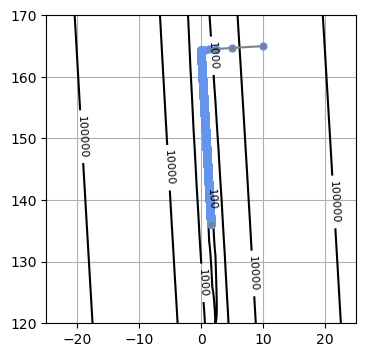

In [44]:
# 勾配法
def fit_line_num(x, t, w_init):
    # パラメータ
    alpha = 0.001  # 学習率
    tau_max = 100000  # 繰り返しの最大数
    eps = 0.1  # 繰り返しをやめる勾配の絶対値の閾値
    # 勾配法
    w = np.zeros((tau_max + 1, 2))  # 重みの履歴を記録する配列
    w[0, :] = w_init                # 初期値の設定
    for tau in range(tau_max):
        dmse = dmse_line(x, t, w[tau, :])   # 勾配の計算
        w[tau + 1, 0] = w[tau, 0] - alpha * dmse[0]  # w0の更新
        w[tau + 1, 1] = w[tau, 1] - alpha * dmse[1]  # w1の更新
        if max(np.absolute(dmse)) < eps:    # 終了判定
            print('max', max(np.absolute(dmse)))
            break
    w_final = w[tau + 1, :]        # 最終の重み
    w_hist = w[: tau + 2, :]           # 重みの履歴 更新した重みも含む
    return w_final, dmse, w_hist

# 勾配法でwを計算
w_init = np.array([10.0, 165.0])  # wの初期値
w, dmse, w_history = fit_line_num(X, T, w_init) # wを計算
mse = mse_line(X, T, w) # 最終の平均2乗誤差

# 結果を表示
print(f'繰り返し回数:{w_history.shape[0]-1}')
print(f'w0 = {w[0]:.6f}, w1 = {w[1]:.6f}')
print(f'dMSE = [{dmse[0]:.6f}, {dmse[1]:.6f}]')
print(f'MSE = {mse:.6f}')
print(f'SD = {np.sqrt(mse):.6f} cm')

# 繰り返し回数とwの値の変化をグラフ表示
plt.figure(figsize=(4, 4))
# 等高線表示
cont = plt.contour(
    ww0, ww1, J,
    colors='black', levels=[100, 1000, 10000, 100000]
)
cont.clabel(fmt='%1.0f', fontsize=8)
# 等高線の上に過去の全てのwの値をプロット
plt.plot(
    w_history[:, 0], w_history[:, 1], 'gray',
    marker='.',
    markersize=10,
    markeredgecolor='cornflowerblue'
)
plt.grid()
plt.show()


In [45]:
# 初めのMSEの値
mse_init = mse_line(X, T, w_init)
print(f'初めのMSEの値：{mse_init:.6f}')
print(f'初めのSDの値：{np.sqrt(mse_init):.6f} cm')

初めのMSEの値：25745.845126
初めのSDの値：160.455119 cm


### 求めたw0とwの値を直線の式に代入してみる

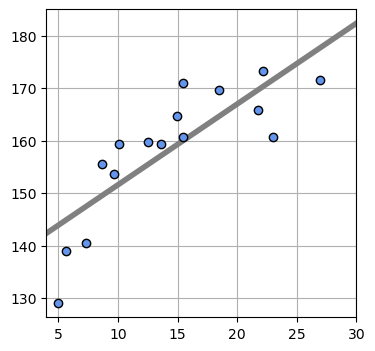

In [46]:
# 線の表示
def show_line(w):
    x = np.linspace(X_min, X_max, 100)
    y = w[0] * x + w[1]
    plt.plot(x, y, color='gray', linewidth=4)

# メイン
# グラフ描画
plt.figure(figsize=(4, 4))
show_line(w)    # 線の表示
plt.plot(
    X, T, 'cornflowerblue',
    marker='o', linestyle='None', markeredgecolor='black'
)

plt.xlim(X_min, X_max)
plt.grid()
plt.show()

### 標準偏差について
平均二乗誤差（MSE）（統計学でいうところの分散）の平方根のことを標準偏差(standard deviation, SD)という

正確な定義としては、「データが正規分布に従っているとき、全体の68％のデータの誤差（平均、回帰線とのずれ）が標準偏差以下となる

## 5.1.5 直線モデルパラメータの解析解
- ### 数値解
  - 数式に数値を入れて繰り返し計算して解いたもの
  - 勾配降下法のようなもの
- ### 解析解
  - 数式の変形のみで求められた解のこと
  - 1回の計算で最適な解が決まる
  - 正確
  - 問題の本質を深く理解することができる

直線でフィッティングするなら解析解が導出できる

### 解析解で解いてみる
1. MSEの式をw0、w1それぞれで微分したものを0とおく（求めたいのは勾配が0の時のw0とw1だから）
2. 平均を<>で括って表す
3. 連立方程式として解く
4. 得られた式がwの解析解

w0 = 1.557575, w1 = 135.871924
MSE = 49.012195
SD = 7.000871 cm


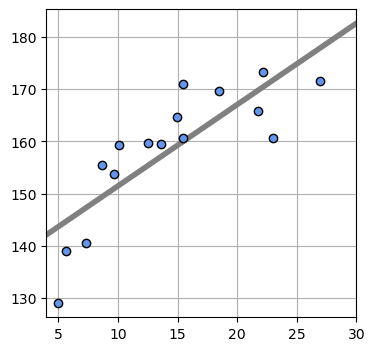

In [55]:
# 解析解で求める
def fit_line(x, t):
    mx = np.mean(x)
    mt = np.mean(t)
    mtx = np.mean(t*x)
    mxx = np.mean(x*x)
    w0 = (mtx - mt * mx) / (mxx - mx ** 2)
    w1 = mt - w0 * mx
    return np.array([w0, w1])

# メイン処理
w = fit_line(X, T)
mse = mse_line(X, T, w)
# 結果を表示
print(f'w0 = {w[0]:.6f}, w1 = {w[1]:.6f}')
print(f'MSE = {mse:.6f}')
print(f'SD = {np.sqrt(mse):.6f} cm')

# グラフ描画
plt.figure(figsize=(4, 4))
show_line(w)    # 線の表示
plt.plot(
    X, T, 'cornflowerblue',
    marker='o', linestyle='None', markeredgecolor='black'
)
plt.xlim(X_min, X_max)
plt.grid()
plt.show()

# 5.2　2次元入力の面モデル

## 5.2.1 問題設定
入力が二次元の重回帰に拡張

年齢だけでなく体重も使って身長を予測する
1. 体重の人口データを作る

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# データのロード
data = np.load('ch5_data.npz')  # 作った身長と年齢のデータ
X0 = data['X']      # これまでのXをX0とする
N = data['N']       # これまでのNはN（データ数）
T = data['T']       # これまでのTはT(身長のデータ)

# 二次元データ(体重）生成
np.random.seed(seed=1)  # 乱数を固定
X1 = 23 * (T / 100) ** 2 + 2 * np.random.randn(N)    # 体重を生成、randnは標準正規分布に従う乱数を生成
X0_min, X0_max = 5, 30      # 年齢の範囲
X1_min, X1_max = 40, 75     # 体重の範囲

データを表示

In [49]:
print('年齢:', np.round(X0, 2))
print('体重:', np.round(X1, 2))
print('身長:', np.round(T, 2))

年齢: [15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]
体重: [70.43 58.15 37.22 56.51 57.32 40.84 57.79 56.94 63.03 65.69 62.33 64.95
 57.73 66.89 46.68 61.08]
身長: [170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


3次元プロットのグラフを表示

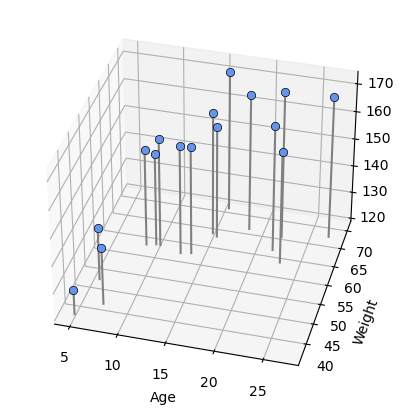

In [52]:
# 二次元データの表示
def show_data2d(ax, x0, x1, t):
    for i in range(len(x0)):
        ax.plot(                # データ点の下の直線を描画
            [x0[i], x0[i]],     # 直線の両端のx座標
            [x1[i], x1[i]],     # 直線の両端のy座標
            [120, t[i]],        # 直線の両端のz座標
            color='gray'
        )
    ax.plot(
        x0, x1, t,                  # データ点の描画(x座標, y座標, z座標)
        color='cornflowerblue',
        marker='o',
        linestyle='None',           # 点を繋ぐ線を書かない
        markeredgecolor='black',
        markersize=6,
        markeredgewidth=0.5
    )
    ax.view_init(elev=35, azim=-75) # グラフの向きの設定(elevation:仰角, azimuth:方位角)

# メイン
plt.figure(figsize=(6, 5))
ax = plt.subplot(projection='3d')
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
show_data2d(ax, X0, X1, T)
plt.show()

## 5.2.2 データの表し方
$x_{nm}$で表す \
nがデータ数・データ番号を表し、\
mが要素・データの種類を表す

## 5.2.3  面モデル
今までは直線を書いてデータを予測したが、二次元ベクトルを入力し学習を行う場合
データに沿った面を描くことができれば、データを予測できる

以下のような式を描画する \
$ y(x) = w_0 x_0 + w_1 x_1 + w_2 $

SD = 12.88 cm


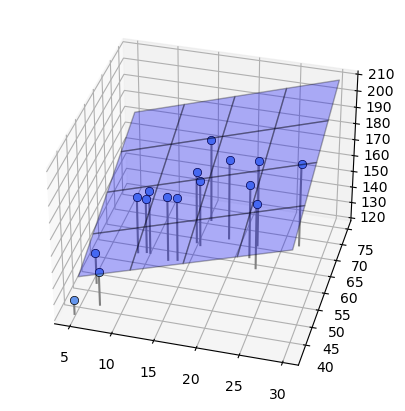

In [53]:
# 面の表示
def show_plane(ax, w):
    # 表示データの計算
    x0_n, x1_n = 5, 5
    x0 = np.linspace(X0_min, X0_max, x0_n)
    x1 = np.linspace(X1_min, X1_max, x1_n)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = w[0] * xx0 + w[1] * xx1 + w[2]
    # 面の描画
    ax.plot_surface(
        xx0, xx1, y, alpha=0.3, color='blue', edgecolor='black',
        rstride=1, cstride=1
    )

# 面の二乗誤差（MSE）関数
def mse_plane(x0, x1, t, w):
    y = w[0] * x0 + w[1] * x1 + w[2]
    mse = np.mean((y - t) ** 2)
    return mse

# メイン
w = np.array([1.5, 1, 90])
mse = mse_plane(X0, X1, T, w)
print(f'SD = {np.sqrt(mse):.2f} cm')

# グラフの表示
plt.figure(figsize=(6, 5))
ax = plt.subplot(projection='3d')
show_plane(ax, w)
show_data2d(ax, X0, X1, T)
plt.show()

## 5.2.4 面モデルパラメータの解析解
先ほどの二次元の入力でも予測できるように学習する

  ＝誤差関数が最小になる最適な重みWを探していく

誤差関数は以下の平均二乗誤差で考える
$$
J = \frac{1}{N} Σ (y(x_n) - t_n)^2 = \frac{1}{N}Σ(w_0x_n,0 + w1 x_n,1 + w_2 - t_n)^2
$$

誤差関数が最小になるということは、その地点の傾きは0であるため

重み$w_0, w_1, w_2$で微分した値が0になるwをそれぞれ求める。

それぞれの偏微分＝0の3式の連立方程式を解くと、分散というデータの散らばりの二乗と、共分散というデータ同士の関係の度合いを表したもので構成された式になる。

そのため、下のコードではまず先に連立方程式の解に必要な分散と共分散を求めている。

w0 = 0.5, w1 = 1.1, w2 = 89.0
SD = 2.55 cm


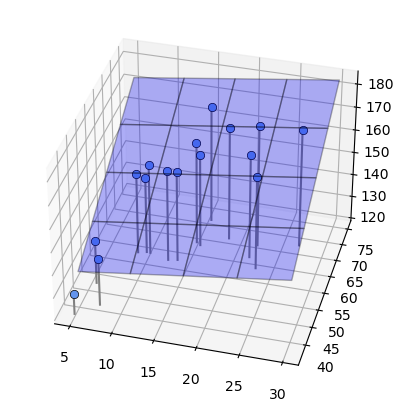

In [54]:
# 解析解　(最小二乗法)によるパラメータの計算
def fit_plane(x0, x1, t):
    # 共分散と分散の計算
    c_tx0 = np.mean(t * x0) - np.mean(t) * np.mean(x0)
    c_tx1 = np.mean(t * x1) - np.mean(t) * np.mean(x1)
    c_x0x1 = np.mean(x0 * x1) - np.mean(x0) * np.mean(x1)
    v_x0 = np.var(x0)
    v_x1 = np.var(x1)
    # パラメータの計算
    w0 = (c_tx1 * c_x0x1 - v_x1 * c_tx0) / (c_x0x1 ** 2 - v_x0 * v_x1)
    w1 = (c_tx0 * c_x0x1 - v_x0 * c_tx1) / (c_x0x1 ** 2 - v_x0 * v_x1)
    w2 = -w0 * np.mean(x0) - w1 * np.mean(x1) + np.mean(t)
    w = np.array([w0, w1, w2])
    return w

# メイン
w = fit_plane(X0, X1, T)
mse = mse_plane(X0, X1, T, w)
# 結果表示
print(f'w0 = {w[0]:.1f}, w1 = {w[1]:.1f}, w2 = {w[2]:.1f}')
print(f'SD = {np.sqrt(mse):.2f} cm')

# グラフの表示
plt.figure(figsize=(6, 5))
ax = plt.subplot(projection='3d')
show_plane(ax, w)
show_data2d(ax, X0, X1, T)
plt.show()

担当：5.2.1-5.2.2 \
来週：5.2.4まで \
13節

# 5.3 D次元線形回帰モデル　（重要！）
xがもっと多次元になった場合、今までのように異なる次元（入力するデータの種類）に対して、一つ一つ対応するのは手間

そこでD次元の入力をDという変数としたまま公式を導くことを考えていく

## 5.3.1 D次元線形回帰モデル
### そもそも線形回帰モデルとは？
一次元入力での直線モデルや、二次元入力で扱った面モデルのように、 \
判断材料となるデータと予測したいデータの関係を、直線のような関数で表現したモデルのこと

### 計算
以下のような式で表される

$ y(x) = w_0 x_0 + w_1 x_1 + ・・・ + w_(D-1) x_(D-1) + w_D $

この節では上の式を切片である$ w_D $を含めずに考える（必ず原点をとおる想定）

そうすると、上式は下のように　wの行列　かける　xの行列　で表すことができる

$ [w_0 ・・・ w_{D-1}] [x_0 ・・・ x_{D-1}]^T = W^TX $

## 5.3.2 パラメータの解析解
多次元のパラメータ（重み）を解析していく

1. 平均二乗誤差の式に上の行列式を代入する
2. それを$w_i$で偏微分 \
  $ w^Tx_n = w_0 x_{n,0} + w_{D-1}x_{n,D-1} $を$w_i$で偏微分すると、$x_{n,i}$だけが残る \
　以下のようになる
  $$
  \frac{∂J}{∂w_i} = \frac{2}{N}Σ(W^TX_n - t_n)x_{n,i} 
  $$
3. 上式が0の時のパラメータを求めたいので、=0の等式を作る \
  両辺を$ \frac{N}{2} $倍する
  $$
  Σ(W^T X_n - t_n) x_{n,i} = 0
  $$
4. ここでようやく行列の考え方を使う \
  3の式は \
  $w_0, w_1...w_{D-1}$ で偏微分されたものが集まったベクトルとも考えられる \
  つまり
  $$
  Σ(W^T X_n - t_n) [x_{n,0},x_{n,1},・・・,x_{n,D-1}] = [0, 0・・・0 ]
  $$

  $ [x_{n,0},x_{n,1},・・・,x_{n,D-1}] $　は行列 $ \boldsymbol{x}_n^T $　なので \

  $$
  Σ(w^T X_n - t_n) \boldsymbol{X}_n^T = [0, 0 ・・・0]
  $$

  その後、
  $ Σ X_n X_n^T = X^T X $　と, $ Σt_n X_n^T = t^T X $　を使って式を変形していくと

  $$
  (\boldsymbol{w}^T \boldsymbol{X}^T \boldsymbol{X} - \boldsymbol{t}^T \boldsymbol{X})^T = [0 0 ・・・0]^T
  $$

5. 転置の計算法則を使って
  $$
  (X^T X)^T (w^T)^T - X^T t = [0, 0 ・・・0]^T
  $$
  
  $$
  (X^T X) w - X^T t = [0, 0 ・・・0]^T
  $$

  $$
  (X^T X) w = X^T t
  $$

  $$
  w = (X^T X) ^{-1} X^T t
  $$

これがD次元回帰モデルの解 \
右辺の、$ (X^T X) ^{-1} X^T $ この部分には　**ムーア・ペンローズの擬似逆行列** という名前がついている

## 5.3.3 原点を通らない面への拡張
今度は原点を通らない面の場合へ拡張していく（切片がある場合）

例えば二次元入力の場合、通常であれば

$ y(x) = w_0 x_0 + w_1 x_1 + w2 $

であるが、

常に1をとる $ x_2 $　を追加して切片がわりにすると、原点に縛られない二次元回帰モデルを作ることができる。

D次元を考える時も同じで、D+1次元目に常に1をとる要素を追加すればOK

# 5.4 線型基底関数
これまでは直線のモデルを使って予測してきたが、曲線を使う

曲線を表す色々なモデルの一つが線形基底関数　→ 汎用性が高い

そして、ガウス関数を基底関数に考える

必要なモジュールをimportしデータをロード

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# データのロード
data = np.load('ch5_data.npz')
X = data['X']
X_min = 0
X_max = data['X_max']
N = data['N']
T = data['T']

ガウス関数を定義
$$
φ_j(x) = exp\{- \frac{(x-μ_j)^2}{2s^2} \}
$$

In [4]:
# ガウス関数
def gauss(x, mu, s):
    y = np.exp(-(x - mu) ** 2 / (2 * s ** 2))
    return y

4つのG関数を年齢の範囲に配置

In [ ]:
# メイン
M = 4                                 # ガウス関数の数
mu = np.linspace(5, 30, M)            # 平均値の初期値
s = mu[1] - mu[0]                     # 標準偏差パラメータ
xb = np.linspace(X_min, X_max, 100)   # 等間隔の100個のxの値
y = np.zeros((M, 100))                # 100個のxに対する4つのガウス関数の出力を格納する行列
for j in range(M):
    plt.plot(xb, y[j, :], 'gray', linewidth=3)     # ガウス関数の計算
plt.xlim(X_min, X_max)
plt.ylim(0, 1.2)

# 5.5 オーバーフィッテング問題

5.3-5.5まで

# 5.6 新しいモデルの生成

# 5.7 モデルの選択

担当　5.7-5.8

5.6-6.1.5まで